# Making Predictions - House Prices Model

## By Jean-Philippe Pitteloud

### Requirements

In [1]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import statsmodels.api as sm
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Data Gathering

In [2]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con = engine)

engine.dispose()


house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


### Modeling and Predicting

#### _Model #1:_

In our first and simpler model, a Linear Regression Model is used using OLS method. The target variable is 'saleprice'. The independent variables included are 'overallqual', 'grlivarea', 'garagearea', 'firstflrsf', and the categorical variables 'exterqual', 'kitchenqual', and 'mszoning'. Upon creating dummy variables for all three categorical variables, however, during previous optimization two dummy variables for the categorical variables 'mszoning' were removed since they did not meet the statistical significance threshold

In [3]:
house_df = pd.concat([house_df,pd.get_dummies(house_df['exterqual'], prefix = 'exterqual_dummy', drop_first=True)], axis = 1)

house_df = pd.concat([house_df,pd.get_dummies(house_df['kitchenqual'], prefix = 'kitchenqual_dummy', drop_first=True)], axis = 1)

house_df = pd.concat([house_df,pd.get_dummies(house_df['mszoning'], prefix = 'mszoning_dummy', drop_first=True)], axis = 1)

To better evaluate the performance of the model, the available data was splitted into "test" and "train" subsets. The "train" subset was then employed to train the model while the "test" data was later used to evaluate the model performance while predicting the values for the target variable

In [4]:
X = house_df[['overallqual', 'grlivarea', 'garagearea', 'firstflrsf', 'exterqual_dummy_Fa', 'exterqual_dummy_Gd', 'exterqual_dummy_TA', 'kitchenqual_dummy_Fa', 'kitchenqual_dummy_Gd', 'kitchenqual_dummy_TA', 'mszoning_dummy_FV', 'mszoning_dummy_RL']]

Y = house_df['saleprice']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [5]:
X_train = sm.add_constant(X_train)

lr_model = sm.OLS(y_train, X_train).fit()

lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.790
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     362.9
Date:                Mon, 14 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:05:52   Log-Likelihood:                -13913.
No. Observations:                1168   AIC:                         2.785e+04
Df Residuals:                    1155   BIC:                         2.792e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.679e+04   1.25e+04      1.341      0.180   -7769.295    4.13e+04
overallqual           1.949e+04   1332.763     14.621      0.000    1.69e+04    2.21e+04
grlivarea               40.8186      2.777     14.701      0.000      35.371      46.266
garagearea              47.4436      6.462      7.342      0.000      34.765      60.122
firstflrsf              14.9869      3.674      4.079      0.000       7.778      22.196
exterqual_dummy_Fa   -3.476e+04   1.48e+04     -2.342      0.019   -6.39e+04   -5645.456
exterqual_dummy_Gd    -3.15e+04   7158.184     -4.400      0.000   -4.55e+04   -1.75e+04
exterqual_dummy_TA   -4.491e+04   7972.899     -5.633      0.000   -6.06e+04   -2.93e+04
kitchenqual_dummy_Fa -4.648e+04   9404.371     -4.943      0.000   -6.49e+04    -2.8e+04
kitchenqual_dummy_Gd -3.373e+04   5448.741     -6.190      0.000   -4.44e+04    -2.3e+04
kitchenqual_dummy_TA -4.236e+04   6052.652     -6.998      0.000   -5.42e+04   -3.05e+04
mszoning_dummy_FV     1.293e+04   6027.878      2.145      0.032    1104.408    2.48e+04
mszoning_dummy_RL     2.203e+04   3071.092      7.173      0.000     1.6e+04    2.81e+04
==============================================================================
Omnibus:                      484.256   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            46819.476
Skew:                          -0.946   Prob(JB):                         0.00
Kurtosis:                      33.959   Cond. No.                     3.57e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Mean absolute error of the prediction is: 23969.088572906687
Mean squared error of the prediction is: 1331986916.2642722
Root mean squared error of the prediction is: 36496.39593527383
Mean absolute percentage error of the prediction is: 14.334190237436301


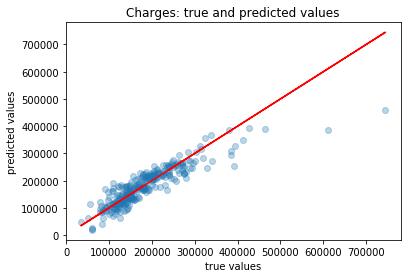

In [6]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = lr_model.predict(X_test)

plt.scatter(y_test, y_preds, alpha = 0.3)
plt.plot(y_test, y_test, color = "red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values");

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

As it can be seen in the summary table above, the adjusted R-squared value obtained was 0.788 indicating that this model explains about 79% of the variance in the target variable. In this particular model, all features were considered statistically significant as judged by their associated p-values. The performance of this model was also evaluated by comparing the predicted values of the target using a sample of the data not used during the model training. Four metrics were estimated based on the difference between the predicted values and the actual values of the target (errors or residuals) and its values listed above

From the plot above, which compares displays the relationship between the predicted and the actual values, we can infer that the model works fairly well except when predicting house prices in the upper range

#### _Model #2:_

In order to optimize the model, two additional predictor variables were included, 'lotarea' and 'fireplaces'. The new model was fitted and evaluated and the summary of the results is presented below. In addition, the dataset was splitted into "train" and "test" subsets to be used during model training and testing respectively

In [7]:
X_2 = house_df[['overallqual', 'grlivarea', 'garagearea', 'firstflrsf', 'lotarea', 'fireplaces', 'exterqual_dummy_Fa', 'exterqual_dummy_Gd', 'exterqual_dummy_TA', 'kitchenqual_dummy_Fa', 'kitchenqual_dummy_Gd', 'kitchenqual_dummy_TA', 'mszoning_dummy_FV', 'mszoning_dummy_RL']]

Y_2 = house_df['saleprice']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, Y_2, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train_2.shape[0]))
print("The number of observations in test set is {}".format(X_test_2.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [8]:
X_train_2 = sm.add_constant(X_train_2)

lr_model_2 = sm.OLS(y_train_2, X_train_2).fit()

lr_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     327.3
Date:                Mon, 14 Oct 2019   Prob (F-statistic):               0.00
Time:                        18:05:52   Log-Likelihood:                -13889.
No. Observations:                1168   AIC:                         2.781e+04
Df Residuals:                    1153   BIC:                         2.788e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 2.632e+04   1.24e+04      2.121      0.034    1972.105    5.07e+04
overallqual           1.914e+04   1324.426     14.455      0.000    1.65e+04    2.17e+04
grlivarea               35.9461      2.816     12.766      0.000      30.422      41.471
garagearea              46.9493      6.347      7.397      0.000      34.497      59.402
firstflrsf               9.9973      3.671      2.723      0.007       2.795      17.200
lotarea                  0.5432      0.105      5.163      0.000       0.337       0.750
fireplaces            7525.5855   1912.996      3.934      0.000    3772.243    1.13e+04
exterqual_dummy_Fa   -3.644e+04   1.45e+04     -2.505      0.012    -6.5e+04   -7897.889
exterqual_dummy_Gd   -3.232e+04   7018.050     -4.606      0.000   -4.61e+04   -1.86e+04
exterqual_dummy_TA   -4.713e+04   7822.442     -6.025      0.000   -6.25e+04   -3.18e+04
kitchenqual_dummy_Fa -4.596e+04   9220.344     -4.984      0.000    -6.4e+04   -2.79e+04
kitchenqual_dummy_Gd -3.359e+04   5342.356     -6.288      0.000   -4.41e+04   -2.31e+04
kitchenqual_dummy_TA -4.284e+04   5934.599     -7.218      0.000   -5.45e+04   -3.12e+04
mszoning_dummy_FV     1.327e+04   5915.494      2.243      0.025    1661.685    2.49e+04
mszoning_dummy_RL     1.881e+04   3045.334      6.175      0.000    1.28e+04    2.48e+04
==============================================================================
Omnibus:                      532.451   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            59370.762
Skew:                          -1.106   Prob(JB):                         0.00
Kurtosis:                      37.858   Cond. No.                     2.64e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

From the table above, we can conclude that this model most succesfully explains the variance in the target with an adjusted R-squared of 0.797. This adjusted R-square value represents an improvement in the explanatory power compared to both Model #1. Once again all included features were estimated as statistically significant. Concerning other metrics such as AIC and BIC, this new model slightly reports just a slight decrease in the values of these metrics. In order to better estimate the predictive power of Model #2, predictions of the target using the "test" subset were calculated and their values compared to the actual values for 'saleprice'

Mean absolute error of the prediction is: 23465.116162244467
Mean squared error of the prediction is: 1309844854.593614
Root mean squared error of the prediction is: 36191.778826048525
Mean absolute percentage error of the prediction is: 14.017521953958767


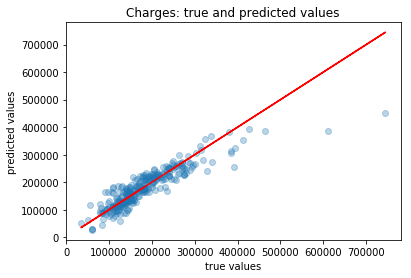

In [9]:
# We add constant to the model as it's a best practice
# to do so every time!
X_test_2 = sm.add_constant(X_test_2)

# We are making predictions here
y_preds_2 = lr_model_2.predict(X_test_2)

plt.scatter(y_test_2, y_preds_2, alpha = 0.3)
plt.plot(y_test_2, y_test_2, color = "red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values");

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test_2, y_preds_2)))
print("Mean squared error of the prediction is: {}".format(mse(y_test_2, y_preds_2)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test_2, y_preds_2)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test_2 - y_preds_2) / y_test_2)) * 100))

From the plot above, we can quickly say that Model #2 does not represent a significant improvement over Model #1. Both models fail to accurately predict the house prices in the upper end of the range. Also, comparison of the evaluation metrics based on the residuals or errors confirm that the new model just slightly improve the predictive power of the original model. Other approaches such as feature engineering and the use of insightful interaction between original features may result in significant improvements of the model performance in the upper range of 'saleprice'